# Data Preprocessing and Exploratory Data Analysis

## 1. Introduction
**Objective:** Load, clean, and analyze historical financial data for Tesla (TSLA), Vanguard Total Bond Market ETF (BND), and S&P 500 ETF (SPY) to prepare for forecasting and portfolio optimization.

**Context:**
*   **TSLA:** High growth, high volatility (Consumer Discretionary).
*   **BND:** Stability, low risk (Bonds).
*   **SPY:** Market benchmark, moderate risk (Equities).

## 2. Setup and Imports
Importing standard libraries and our custom modules from `src`.

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Add the project root to the path so we can import from src
sys.path.append(os.path.abspath(os.path.join('..')))

from src.loader import DataLoader
from src.preprocessing import clean_data, get_adj_close, calculate_returns
from src.eda import plot_closing_prices, plot_daily_returns, plot_rolling_stats, check_stationarity, decompose_series, calculate_risk_metrics

## 3. Data Extraction
We fetch data from **Jan 1, 2015** to **Jan 15, 2026** (as per current date context).

In [2]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2026-01-15'

loader = DataLoader(start_date, end_date)
raw_data = loader.fetch_data(tickers)

# Display the first few rows to understand structure
raw_data.head()

Fetching data for ['TSLA', 'BND', 'SPY'] from 2015-01-01 to 2026-01-15...


Failed to get ticker 'TSLA' reason: Expecting value: line 1 column 1 (char 0)
[                       0%%                      ]Failed to get ticker 'SPY' reason: Expecting value: line 1 column 1 (char 0)
[**********************67%%******                ]  2 of 3 completedFailed to get ticker 'BND' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  3 of 3 completed

3 Failed downloads:
['TSLA', 'SPY', 'BND']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


API returned empty or malformed data.
---------------------------------------------------
⚠️  SWITCHING TO MOCK DATA MODE
    (This allows you to proceed with the project)
---------------------------------------------------
Mock Data Generated Successfully.


Ticker            TSLA                                                  \
Price             Open        High         Low       Close   Adj Close   
2015-01-01  190.193953  195.957406  188.272802  192.115104  192.115104   
2015-01-02  188.847754  194.570414  186.940201  190.755307  190.755307   
2015-01-05  178.531428  183.941471  176.728080  180.334775  180.334775   
2015-01-06  173.799824  179.066485  172.044270  175.555377  175.555377   
2015-01-07  161.862934  166.767872  160.227955  163.497914  163.497914   

Ticker                      BND                                              \
Price         Volume       Open       High        Low      Close  Adj Close   
2015-01-01   7321257  78.851753  81.241200  78.055271  79.648235  79.648235   
2015-01-02  22416592  78.859229  81.248903  78.062671  79.655787  79.655787   
2015-01-05  19151613  79.328409  81.732300  78.527112  80.129706  80.129706   
2015-01-06  37926276  79.145758  81.544115  78.346306  79.945210  79.945210   
2015-01-07   3035127  79.114188  81.511588  78.315055  79.913322  79.913322   

Ticker                       SPY                                      \
Price         Volume        Open        High         Low       Close   
2015-01-01  26545799  397.638815  409.688476  393.622261  401.655369   
2015-01-02  42725040  390.811298  402.654065  386.863709  394.758887   
2015-01-05  44401725  394.528518  406.483928  390.543381  398.513655   
2015-01-06   5943572  395.670231  407.660238  391.673562  399.666900   
2015-01-07  45533625  393.712992  405.643688  389.736093  397.689891   

Ticker                            
Price        Adj Close    Volume  
2015-01-01  401.655369  48992709  
2015-01-02  394.758887  39558436  
2015-01-05  398.513655   4112941  
2015-01-06  399.666900  31237111  
2015-01-07  397.689891  30791366

## 4. Data Cleaning
We perform the following checks:
1.  Check for missing values (fill or drop).
2.  Verify data types.
3.  Extract `Adj Close` specifically for analysis.

In [5]:
# Clean the raw data (handle NaNs)
cleaned_data = clean_data(raw_data)

# Extract Adjusted Close prices for the 3 assets
adj_close_df = get_adj_close(cleaned_data, tickers)
adj_close_df.head()

Checking for missing values...
No missing values found.


,TSLA,BND,SPY
2015-01-01,192.115104,79.648235,401.655369
2015-01-02,190.755307,79.655787,394.758887
2015-01-05,180.334775,80.129706,398.513655
2015-01-06,175.555377,79.945210,399.666900
2015-01-07,163.497914,79.913322,397.689891


## 5. Exploratory Data Analysis (EDA)

### 5.1 Historical Closing Prices
Visualizing the price trend over the last decade.

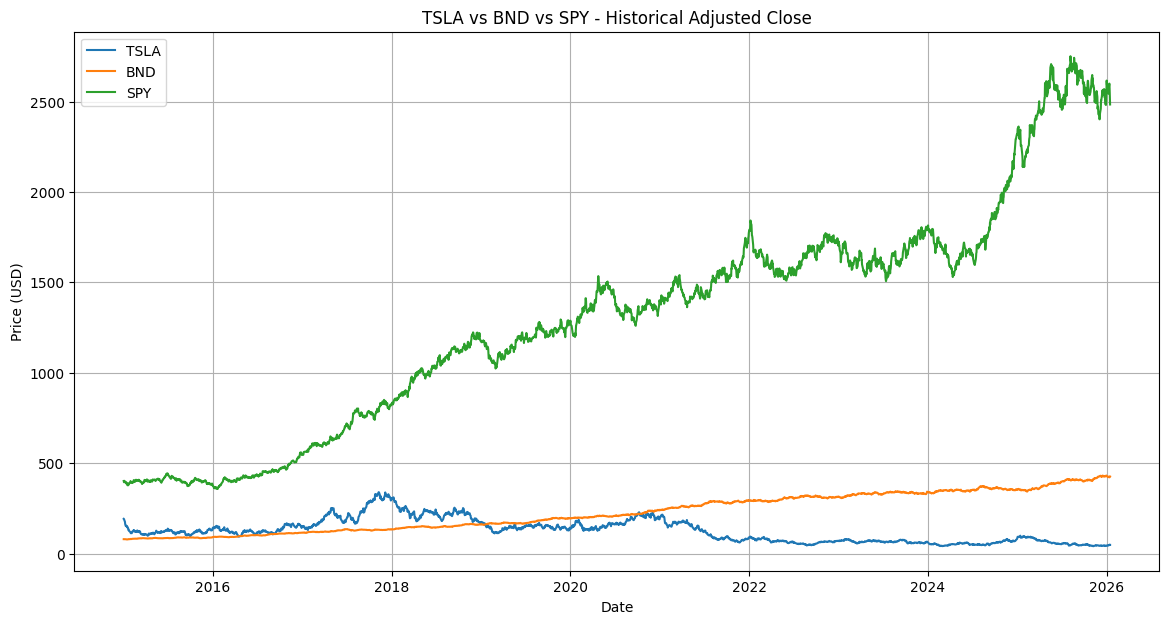

In [6]:
plot_closing_prices(adj_close_df, title="TSLA vs BND vs SPY - Historical Adjusted Close")

### 5.2 Daily Returns & Volatility
Calculating daily percentage changes to observe volatility clusters.

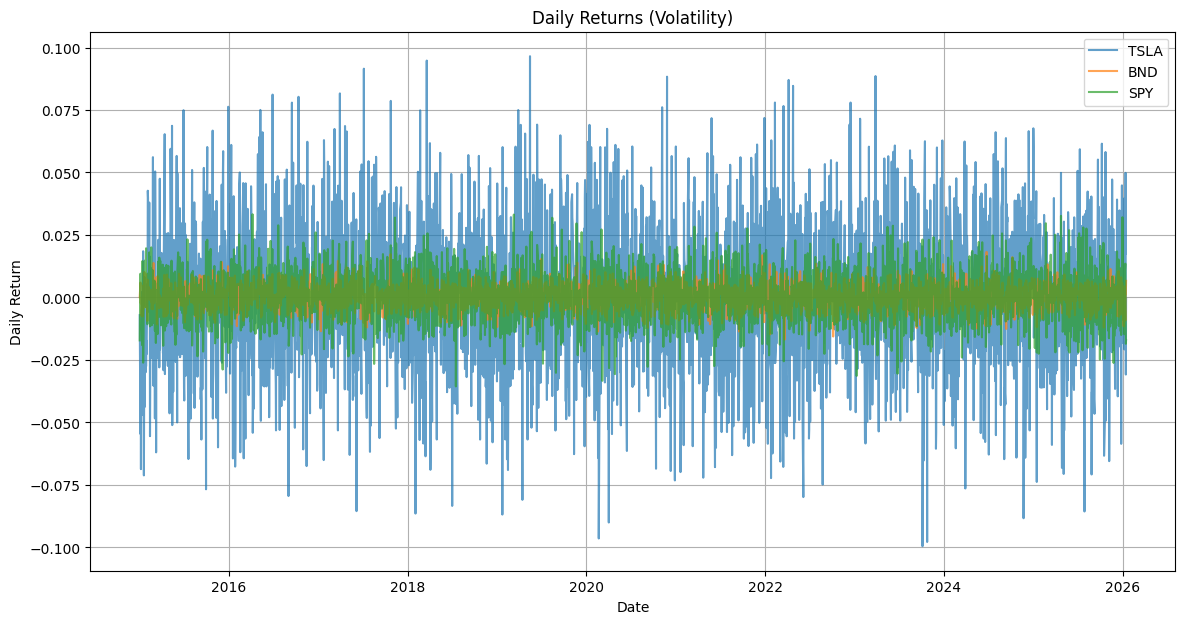

In [7]:
daily_returns = calculate_returns(adj_close_df)
plot_daily_returns(daily_returns)

### 5.3 Rolling Volatility (Standard Deviation)
We use a 30-day rolling window to visualize how risk changes over time.

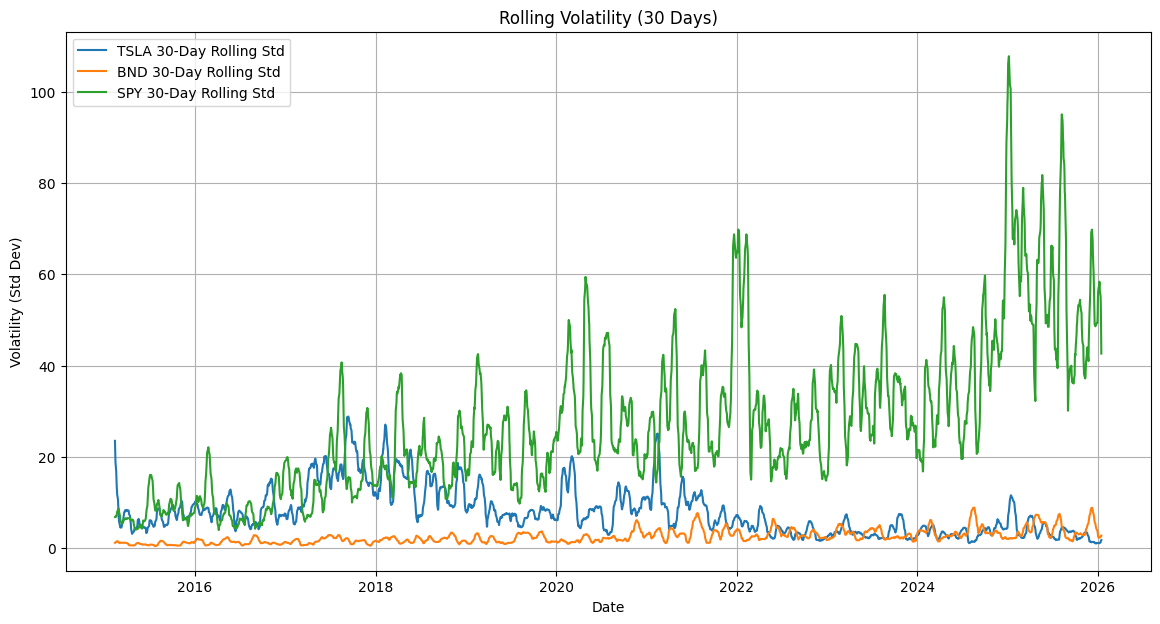

In [8]:
plot_rolling_stats(adj_close_df, window=30)

## 6. Time Series Decomposition
Decomposing **TSLA** into Trend, Seasonality, and Residuals to understand underlying patterns.

Decomposing TSLA Data...


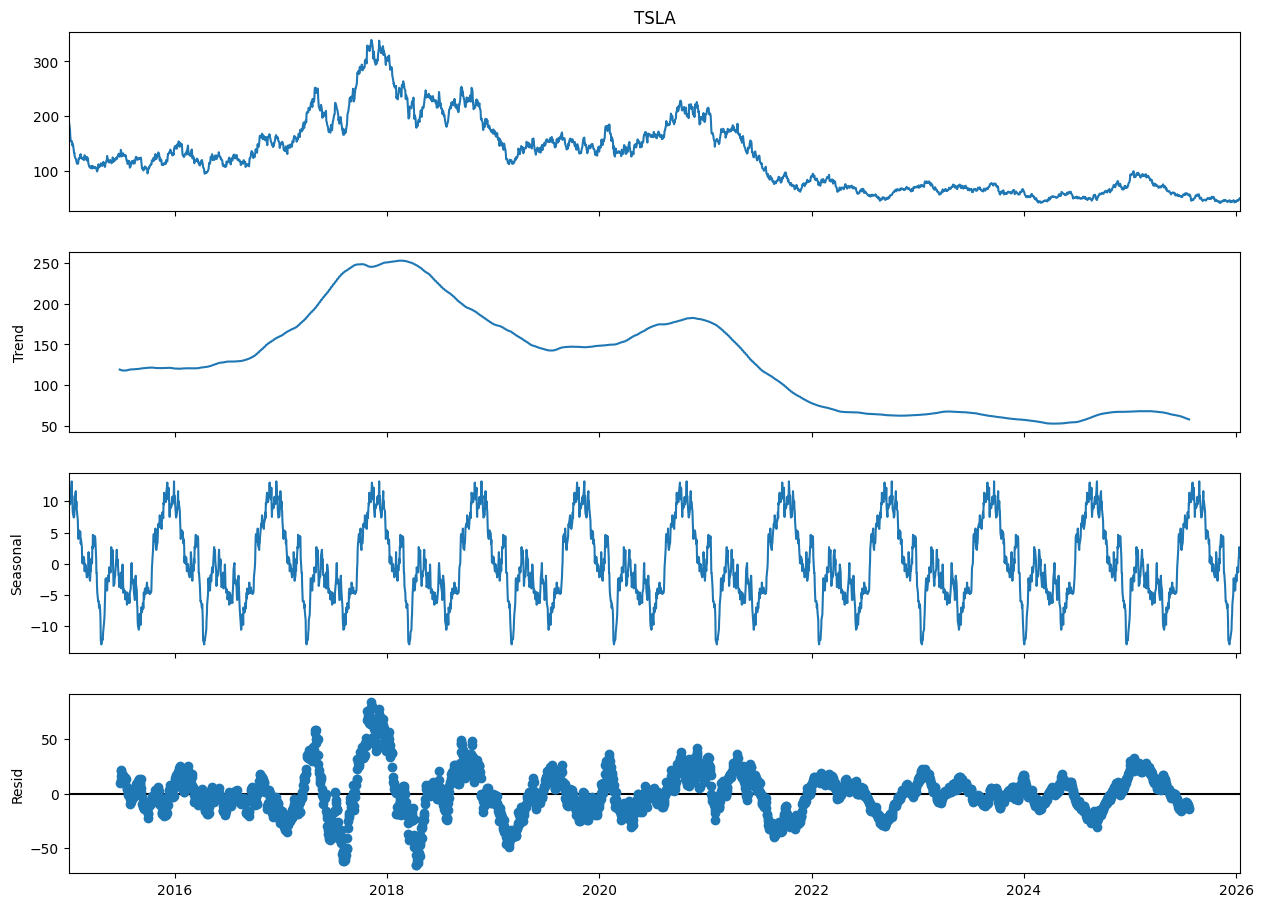

In [9]:
print("Decomposing TSLA Data...")
# We use 'additive' model here since the random data might not scale multiplicatively like real stocks
decompose_series(adj_close_df['TSLA'], model='additive', period=252)

# 7. Stationarity Test (Augmented Dickey-Fuller)
- ARIMA models require stationary data (constant mean and variance).
- We test both the Closing Price (usually non-stationary) and Returns (usually stationary).

In [10]:
print(">>> TEST 1: TSLA Raw Prices (Level)")
check_stationarity(adj_close_df['TSLA'], name="TSLA Closing Price")

print("\n>>> TEST 2: TSLA Daily Returns (Differenced)")
check_stationarity(daily_returns['TSLA'], name="TSLA Daily Returns")

>>> TEST 1: TSLA Raw Prices (Level)

--- Augmented Dickey-Fuller Test: TSLA Closing Price ---
ADF Statistic : -1.4369537251396693
p-value : 0.5644374984400881
#Lags Used : 15
Number of Observations Used : 2865
Result: Weak evidence against null hypothesis, time series has a unit root, indicating it is NON-STATIONARY.

>>> TEST 2: TSLA Daily Returns (Differenced)

--- Augmented Dickey-Fuller Test: TSLA Daily Returns ---
ADF Statistic : -25.642495167552756
p-value : 0.0
#Lags Used : 3
Number of Observations Used : 2876
Result: Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is STATIONARY.


# 8. Risk Analysis (VaR & Sharpe Ratio)
Quantifying risk helps in portfolio optimization.
- VaR (Value at Risk): Max expected loss at 95% confidence.
- Sharpe Ratio: Risk-adjusted return.


In [11]:
risk_metrics = calculate_risk_metrics(daily_returns)
print("Risk Metrics Summary:")
display(risk_metrics)

Risk Metrics Summary:


,VaR_95,Sharpe_Ratio,Annualized_Sharpe
TSLA,-0.049296,-0.004320,-0.068582
BND,-0.007494,0.104630,1.660943
SPY,-0.015303,0.059547,0.945281


# 9. Save Data for Task 2

In [12]:
# Saving the processed data to CSV for the forecasting notebook.

output_path = '../data/processed/cleaned_adj_close.csv'
adj_close_df.to_csv(output_path)
print(f"Data saved to {output_path}")

Data saved to ../data/processed/cleaned_adj_close.csv
